In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from keras.optimizers import RMSprop, Adam, SGD, Adadelta
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split

from datetime import datetime
from packaging import version
import tensorflow as tf
from tensorflow import keras

import tensorboard
tensorboard.__version__

'2.18.0'

In [19]:
def load_data (data_path):
    # Get emotion categories (folder names)
    categories = sorted(os.listdir(data_path))  # Ensure consistent ordering
    print("Categories:", categories)

    # Map categories to numerical labels
    label_map = {category: idx for idx, category in enumerate(categories)}
    print("Label Map:", label_map)

    images = []
    labels = []
    
    for category, label in label_map.items():
        category_path = os.path.join(data_path, category)
        
        # Load all images in the category folder
        for file in os.listdir(category_path):
            file_path = os.path.join(category_path, file)
            image = cv2.imread(file_path)
            images.append(image)
            labels.append(label)

    return images, labels

In [20]:
images, labels = load_data("Dataset/EyeDataset")
df = pd.DataFrame({
    'image': [img.tolist() for img in images],
    'label': labels
})

Categories: ['close_look', 'forward_look', 'left_look', 'right_look']
Label Map: {'close_look': 0, 'forward_look': 1, 'left_look': 2, 'right_look': 3}


In [21]:
df.head()

,image,label
0,"[[[125, 125, 125], [124, 124, 124], [124, 124,...",0
1,"[[[98, 98, 98], [99, 99, 99], [101, 101, 101],...",0
2,"[[[146, 146, 146], [146, 146, 146], [144, 144,...",0
3,"[[[75, 75, 75], [75, 75, 75], [75, 75, 75], [7...",0
4,"[[[114, 114, 114], [114, 114, 114], [114, 114,...",0


In [22]:
df.count()

image    14360
label    14360
dtype: int64

In [23]:
#save to csv
df.to_csv('Dataset/EyeDataset.csv', index=False)

In [5]:
#resize the image
def resize_image(image, target_size=(60, 60)):
    # Convert the image to a NumPy array if it's not already
    if isinstance(image, str):
        image = eval(image)  # Convert string representation of list to actual list
    image_array = np.array(image, dtype=np.uint8)
    
    # Resize the image
    resized_image = cv2.resize(image_array, target_size)
    return resized_image

In [6]:
#transform grayscale images
def to_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [30]:
#resize the image
df['image'] = df['image'].apply(resize_image, target_size=(60, 60))

In [33]:
# Verify the shape of the resized images
df['image_shape'] = df['image'].apply(lambda img: img.shape)
print(df['image_shape'].value_counts())

# Drop the 'image_shape' column after verification
df.drop(columns=['image_shape'], inplace=True)

print(df.head())

image_shape
(60, 60, 3)    14360
Name: count, dtype: int64
                                               image  label
0  [[[125, 125, 125], [124, 124, 124], [123, 123,...      0
1  [[[98, 98, 98], [101, 101, 101], [102, 102, 10...      0
2  [[[145, 145, 145], [144, 144, 144], [143, 143,...      0
3  [[[75, 75, 75], [75, 75, 75], [75, 75, 75], [7...      0
4  [[[114, 114, 114], [114, 114, 114], [114, 114,...      0


In [ ]:
#transform the image
df['image'] = df['image'].apply(to_grayscale)

In [38]:
df['image_shape'] = df['image'].apply(lambda img: img.shape)
print(df['image_shape'].value_counts())

# Drop the 'image_shape' column after verification
df.drop(columns=['image_shape'], inplace=True)

print(df.head())

image_shape
(60, 60)    14360
Name: count, dtype: int64
                                               image  label
0  [[125, 124, 123, 126, 126, 126, 126, 126, 126,...      0
1  [[98, 101, 102, 103, 103, 104, 105, 106, 108, ...      0
2  [[145, 144, 143, 141, 141, 140, 136, 137, 136,...      0
3  [[75, 75, 75, 76, 78, 79, 83, 84, 85, 84, 86, ...      0
4  [[114, 114, 114, 114, 114, 114, 114, 114, 114,...      0


In [45]:
img_array = np.stack(df['image'], axis=0)

In [46]:
print(img_array.shape)

(14360, 60, 60)


In [57]:
X_train,X_test,y_train,y_test = train_test_split(img_array, df['label'], test_size=0.2, random_state=42)

In [58]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((11488, 60, 60), (2872, 60, 60), (11488,), (2872,))

In [59]:
X_train = X_train / 255
X_test = X_test / 255

In [78]:
"""Construct the CNN model"""
CNN_Model = Sequential([
    layers.Conv2D(filters=16,kernel_size=(3,3),activation='relu', input_shape=(60,60,1)),
    layers.MaxPooling2D(pool_size=(2, 2),strides=None,padding='valid'),
    layers.Dropout(0.25),

    layers.Conv2D(filters=16,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2),strides=None,padding='valid'),
    layers.Dropout(0.25),

    layers.Conv2D(filters=16,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2),strides=None,padding='valid'),
    layers.Dropout(0.25),

    layers.Flatten(),
    
    layers.Dense(400,activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(4,activation='softmax') # Final Layer using Softmax
    
    ])

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [79]:
""" COMPILE The Model """
CNN_Model.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy',metrics = ['acc'])

In [80]:
""" FIT THE MODEL"""
FITCNN= CNN_Model.fit(X_train, y_train,validation_data = (X_test, y_test) ,epochs = 30,verbose = 1 )

Epoch 1/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - acc: 0.5516 - loss: 1.0054 - val_acc: 0.9042 - val_loss: 0.3627
Epoch 2/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - acc: 0.8621 - loss: 0.3745 - val_acc: 0.9373 - val_loss: 0.2112
Epoch 3/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - acc: 0.9209 - loss: 0.2412 - val_acc: 0.9593 - val_loss: 0.1376
Epoch 4/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - acc: 0.9402 - loss: 0.1871 - val_acc: 0.9687 - val_loss: 0.1179
Epoch 5/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - acc: 0.9536 - loss: 0.1462 - val_acc: 0.9777 - val_loss: 0.1030
Epoch 6/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - acc: 0.9580 - loss: 0.1291 - val_acc: 0.9756 - val_loss: 0.0828
Epoch 7/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - acc: 0.9669 - loss: 0.1060 - val_acc: 0.9774 - val_loss: 0.0803
Epoch 8/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - acc: 0.9672 - loss: 0.0986 - val_acc: 0.9822 - val_loss: 0.0625
Epoch 9/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - a

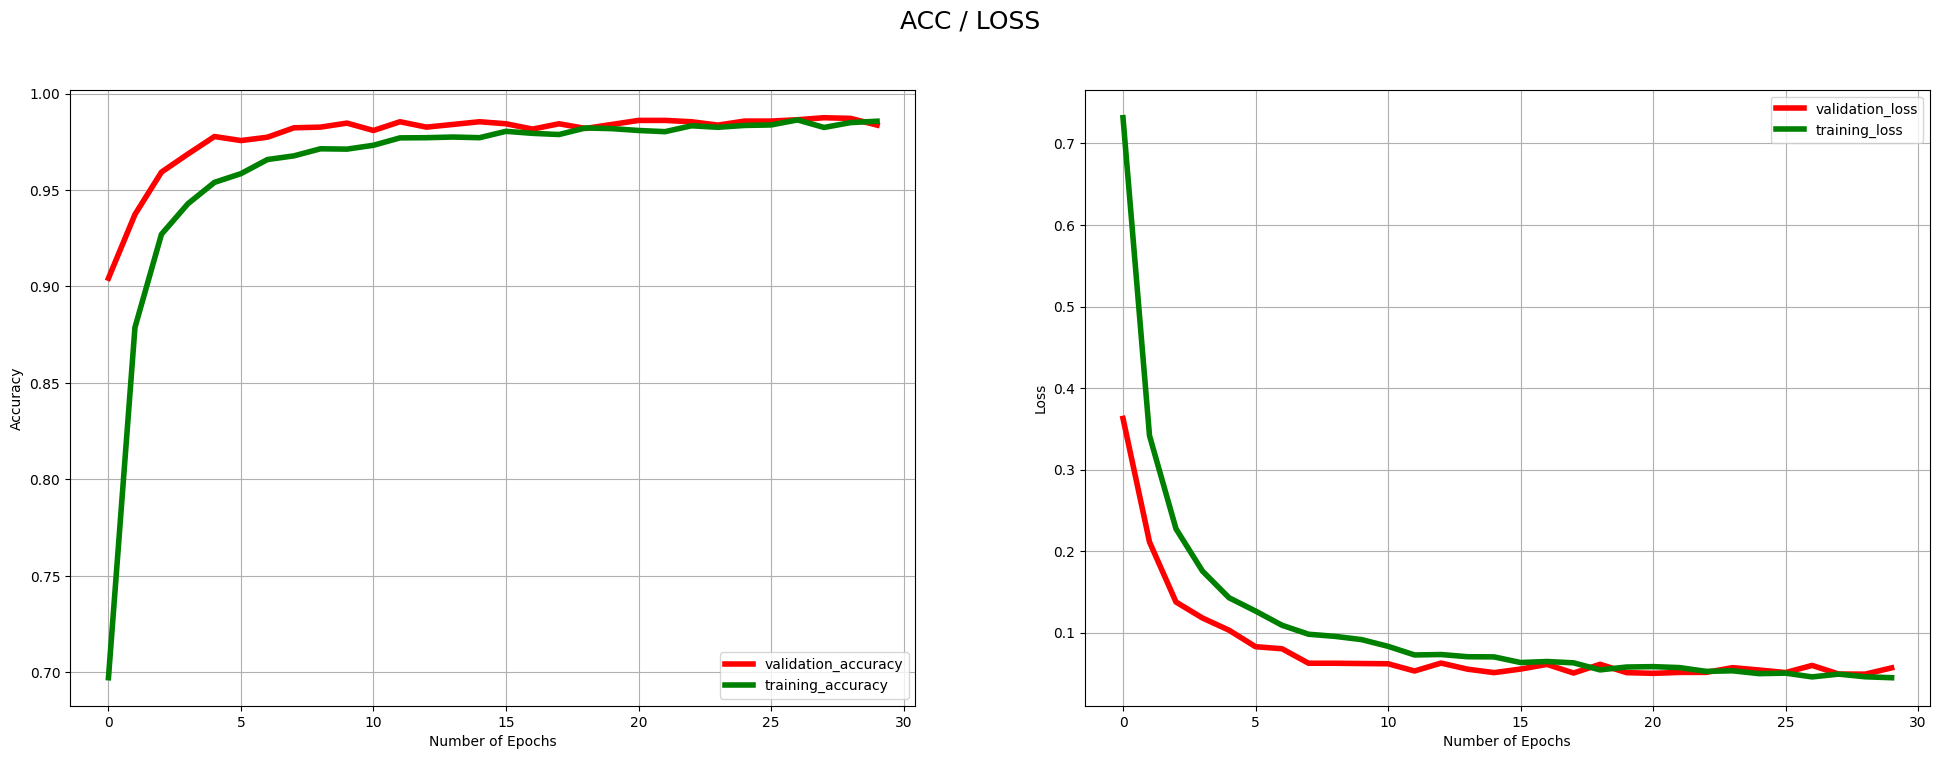

In [81]:
plt.figure(figsize=(24,8))
plt.subplot(1,2,1)
plt.plot(FITCNN.history["val_acc"], label="validation_accuracy", c="red", linewidth=4)
plt.plot(FITCNN.history["acc"], label="training_accuracy", c="green", linewidth=4)
plt.ylabel("Accuracy")
plt.xlabel("Number of Epochs")
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(FITCNN.history["val_loss"], label="validation_loss", c="red", linewidth=4)
plt.plot(FITCNN.history["loss"], label="training_loss", c="green", linewidth=4)
plt.ylabel("Loss")
plt.xlabel("Number of Epochs")
plt.legend()
plt.grid(True)

plt.suptitle("ACC / LOSS",fontsize=18)
plt.show()

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       778
           1       0.96      0.99      0.98       673
           2       1.00      0.97      0.99       724
           3       0.98      0.97      0.97       697

    accuracy                           0.98      2872
   macro avg       0.98      0.98      0.98      2872
weighted avg       0.98      0.98      0.98      2872



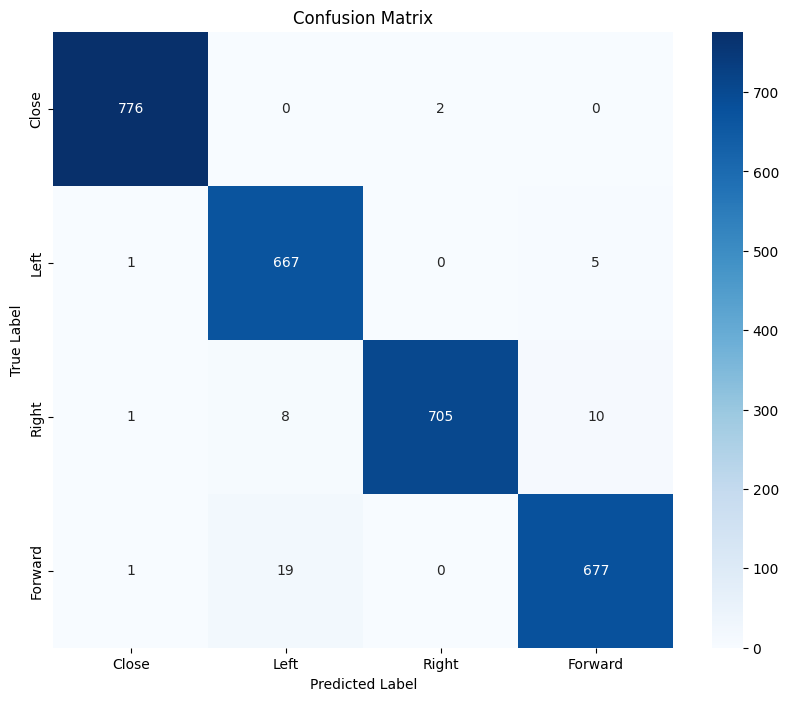

In [82]:
#show confusion matrix and classification report
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

EYEGAZE = ["Close","Left","Right","Forward"]

predictions = CNN_Model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=EYEGAZE, columns=EYEGAZE)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [83]:
#save the model
CNN_Model.save("EyeGaze_Model.h5")

In [3]:
EYEGAZE = ["Close","Forward","Left","Right"]
#load model and test
model = tf.keras.models.load_model("EyeGaze_Model.h5")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Forward


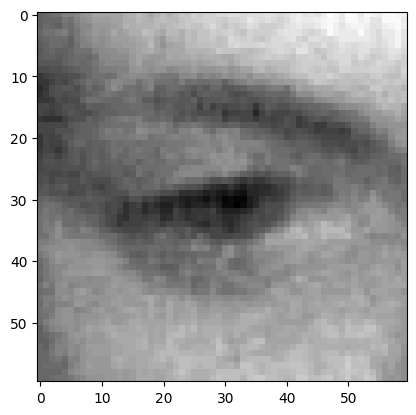

In [13]:
#load the image
img1 = cv2.imread("Dataset/EyeDataset/close_look/eye_closed(3809).png")
img2 = cv2.imread("Dataset/EyeDataset/forward_look/forward_look (3).png")
img3 = cv2.imread("Dataset/EyeDataset/left_look/left_(2).png")
img4 = cv2.imread("Dataset/EyeDataset/right_look/right_(0).png")

img = resize_image(img2, target_size=(60, 60))
img = to_grayscale(img)
img = img / 255
#convert numpy array
img = np.array([img])

#predict the image
pred = model.predict(img)
#print(pred)
pred = np.argmax(pred)
#print(pred)
#show the image
plt.imshow(img[0], cmap='gray')
print(EYEGAZE[pred])